## COMP5625M Assessment 2 - Image Caption Generation [100 marks]

<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!** 

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

ml21s2j

Your full name:

Shengxuan Ji

### Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import os
import torch.optim as optim
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter


Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) --> 


<div>
<center><img src="comp5625M_figure_imageCaption.jpg" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features. 


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features [11 marks]

> 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> 1.2 Image feature extraction step (7 marks)

#### 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [3]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        # Your code here!

        # keep all layers of the pretrained net except the last layers of fully-connected ones (you are permitted to take other layers too but this can affect your accuracy!)
        # Load the pretrained ResNet-50 model
        resnet = models.resnet50(pretrained=True)
        # Remove the last fully connected layer (fc)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # Disable gradient computation for the encoder
        for param in self.resnet.parameters():
            param.requires_grad = False

        
    def forward(self, images):
        """Extract feature vectors from input images."""
        # remember no gradients are needed
        # return features 
        
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        return features



In [4]:
# instantiate encoder and put into evaluation mode.
# Your code here!
encoder = EncoderCNN()
encoder.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

#### 1.2 Image feature extraction step (7 marks)

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [5]:
from torchvision import transforms
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [6]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("/kaggle/input/cw2-data/coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

,file_name
0,000000000009.jpg
1,000000000025.jpg
2,000000000030.jpg
3,000000000034.jpg
4,000000000036.jpg
...,...
5063,000000581906.jpg
5064,000000581909.jpg
5065,000000581913.jpg
5066,000000581921.jpg


In [8]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch 

IMAGE_DIR = "/kaggle/input/cw2-data/coco/images"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        # --> your code here!
        self.transform = transform


    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']

        # --> your code here!
        img_path = f"{IMAGE_DIR}/{filename}"
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, filename

    def __len__(self):
        return len(self.df)
    

In [9]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise
# Your code here-->

# Create an instance of the COCOImagesDataset class
coco_dataset = COCOImagesDataset(df_unique_files, transform=data_transform)

# Create a DataLoader to load the images in batches
batch_size = 64
data_loader = DataLoader(coco_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [11]:
from tqdm.notebook import tqdm
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# Hint - make sure to save your features after running this - you can use torch.save to do this
encoder_d = encoder.to(device)

features_map = dict()

with torch.no_grad():
    for images, image_ids in tqdm(data_loader, desc="Extracting features"):
        images_d = images.to(device)
        features = encoder_d(images_d)
        for image_id, feature in zip(image_ids, features):
            features_map[image_id] = feature.cpu().numpy()

torch.save(features_map, "/kaggle/working/image_features_map.pth")

Extracting features:   0%|          | 0/80 [00:00<?, ?it/s]

## 2 Text preparation [23 marks]

> 2.1 Build the caption dataset (3 Marks)

> 2.2 Clean the captions (3 marks)

> 2.3 Split the data (3 marks)

> 2.4 Building the vocabulary (10 marks)

> 2.5 Prepare dataset using dataloader (4 marks)


#### 2.1 Build the caption dataset (3 Marks)

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [12]:
import json

# loading captions for training
with open('/kaggle/input/cw2-data/coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [13]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv("/kaggle/input/cw2-data/coco_subset_meta.csv")
# coco_subset.head(5)
# --> your code here! - name the new dataframe as "new_file"

# Merge the dataframes on 'id' column
joined_df = df.merge(coco_subset[['id', 'file_name']], how='inner', left_on='image_id', right_on='id',sort = True)
new_file = joined_df[['image_id', 'id_x', 'caption','file_name']].drop_duplicates()
new_file = new_file.rename(columns={'id_x': 'id'})

# Select the desired columns
# new_file[new_file['image_id'] == 25]
new_file.head()

,image_id,id,caption,file_name
0,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg
3,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg
6,9,663627,there are containers filled with different kin...,000000000009.jpg
9,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg
12,9,667602,A bunch of trays that have different food.,000000000009.jpg


#### 2.2 Clean the captions (3 marks)

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [21]:
import re
new_file["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(df):

    # Remove spaces in the beginning and at the end
    # Convert to lower case
    # Replace all non-alphabet characters with space
    # Replace all continuous spaces with a single space

    # -->your code here
    clean_captions = []

    for caption in df["caption"]:
        # Remove spaces in the beginning and at the end
        caption = caption.strip()

        # Convert to lower case
        caption = caption.lower()

        # Replace all non-alphabet characters with space
        caption = re.sub(r"[^a-z]+", " ", caption)

        # Replace all continuous spaces with a single space
        caption = re.sub(r"\s+", " ", caption)

        clean_captions.append(caption)

    # Add cleaned captions to the DataFrame
    df["clean_caption"] = clean_captions

    return df


In [22]:
# clean and print 10 of these
new_file_clean = gen_clean_captions_df(new_file)
new_file_clean.head(10)

,image_id,id,caption,file_name,clean_caption
0,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg,closeup of bins of food that include broccoli ...
3,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg,a meal is presented in brightly colored plasti...
6,9,663627,there are containers filled with different kin...,000000000009.jpg,there are containers filled with different kin...
9,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg,colorful dishes holding meat vegetables fruit ...
12,9,667602,A bunch of trays that have different food.,000000000009.jpg,a bunch of trays that have different food
15,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg,a giraffe eating food from the top of the tree
16,25,127076,A giraffe standing up nearby a tree,000000000025.jpg,a giraffe standing up nearby a tree
17,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg,a giraffe mother with its baby in the forest
18,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg,two giraffes standing in a tree filled area
19,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg,a giraffe standing next to a forest filled wit...


#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [23]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]



In [24]:
import random
import math

# Get the unique image IDs
unique_image_ids = new_file_clean['image_id'].unique()

# Split the unique image IDs into train, validation, and test sets
random.seed(64)
train_ids, valid_ids, test_ids = split_ids(unique_image_ids, train=0.7, valid=0.1, test=0.2)

# Create separate DataFrames for each set based on the image IDs
train_df = new_file_clean[new_file_clean['image_id'].isin(train_ids)]
valid_df = new_file_clean[new_file_clean['image_id'].isin(valid_ids)]
test_df = new_file_clean[new_file_clean['image_id'].isin(test_ids)]

# Display the size of each set
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 17742
Validation set size: 2530
Test set size: 5077


#### 2.4 Building the vocabulary (10 marks)

The vocabulary consists of all the possible words which can be used - <u>both as input into the model, and as output predictions</u>, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [19]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [20]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'])
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        # --> Your code here!
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)
    return vocab


In [25]:
# build your vocabulary for train, valid and test sets
# ---> your code here!
# Build the vocabulary using the train and validation sets
combined_ids = np.concatenate((train_ids, valid_ids), axis=0)
vocab = build_vocab(combined_ids, new_file_clean)
print(f"Total vocabulary size: {vocab.__len__()}")

Total vocabulary size: 2509


#### 2.5 Prepare dataset using dataloader (4 marks)

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [26]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        # TO COMPLETE
        self.df = df
        self.features = features
        self.vocab = vocab
    
    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """   
        
       # TO COMPLETE
        # Feature
#         print(index)
        file_name = self.df.iloc[index]['file_name']
        feature = self.features[file_name]
        feature = torch.from_numpy(feature).unsqueeze(0)
        
        # target caption
        # length
        caption = self.df.iloc[index]['clean_caption']
        tokens = caption.split()
        caption_ids = []
        caption_ids.extend([self.vocab(token) for token in tokens])
        caption_ids.append(self.vocab('<end>'))

        target = torch.zeros(MAX_SEQ_LEN).long()
        target[:len(caption_ids)] = torch.tensor(caption_ids)
        length = torch.tensor(len(caption_ids))

        return (feature, target, length)
        
    def __len__(self):
#         return len(self.features)
        return len(self.df)

In [27]:
def caption_collate_fn(data):
    # type(data) list
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    
    # --> Your code here
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: x[2], reverse=True)
    images, targets, lengths = zip(*data) # Tuples

    # merge images (from tuple of 3D tensor to 4D tensor).
    # if using features, 2D tensor to 3D tensor. (batch_size, 256)
    images = torch.stack(images, 0)

    # merge captions (from tuple of 1D tensor to 2D tensor).
    targets = torch.stack(targets, 0)

    # pad with zeros
    padded_targets = torch.zeros(len(targets), MAX_SEQ_LEN).long()
    for i, target in enumerate(targets):
        end = lengths[i]
        padded_targets[i, :end] = target[:end]

    return images, padded_targets, lengths


In [15]:
features_path = '/kaggle/input/Dataset/image_features_map.pth'
features_map = torch.load(features_path)
# features_map

In [28]:
dataset_train = COCO_Features(
    df=train_df,
    vocab=vocab,
    features=features_map,
)

#  your dataloader here (make shuffle true as you will be training RNN)
# --> your code here!
train_loader = DataLoader(
    dataset_train,
    batch_size=64,  # You can set the batch size as needed
    shuffle=True,
    collate_fn=caption_collate_fn,
)


# Do the same as above for your validation set
# ---> your code here!
dataset_valid = COCO_Features(
    df=valid_df,
    vocab=vocab,
    features=features_map,
)

valid_loader = DataLoader(
    dataset_valid,
    batch_size=64,
    shuffle=False,
    collate_fn=caption_collate_fn
)


Load one batch of the training set and print out the shape of each returned Tensor.

In [29]:
# Load one batch of the training set
images, targets, lengths = next(iter(train_loader))
# Print the shape of each returned Tensor
print(f"Images shape: {images.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Lengths shape: {len(lengths)}")

Images shape: torch.Size([64, 1, 2048])
Targets shape: torch.Size([64, 47])
Lengths shape: 64


## 3 Train DecoderRNN [20 marks]

> 3.1 Design RNN-based decoder (10 marks)

> 3.2 Train your model with precomputed features (10 Marks)

#### 3.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [51]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer 
        # (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, 
        # other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize your code
        
        # batch normalisation helps to speed up training
        # your code
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01,track_running_stats=False)

        # your code for embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.resize = nn.Linear(2048, embed_size)
        # your code for RNN
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        
        # self.linear: linear layer with input: hidden layer, output: vocab size
        # --> your code
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        
        self.max_seq_length = max_seq_length
        
        self.lossfunction = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 0.001)
        
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        features = features.view(features.shape[0], 2048)
        
        embeddings = self.embed(captions)
        im_features = self.resize(features)
#         print(im_features)
#         print(im_features.shape)
        im_features = self.bn(im_features)
        
        # compute your feature embeddings
        # your code
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)
    
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.rnn(packed)

        outputs = self.linear(hiddens[0])
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [52]:
# instantiate decoder
# your code here!
vocab_size = vocab.__len__()
decoder = DecoderRNN(vocab_size = vocab_size)

#### 3.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the <u>features, reference captions, and targets to the decoder</u>, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [32]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [53]:
# training function
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, loss_fn, results_path):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.results_path = results_path
        
    def train(self, nepochs):
        statsrec = np.zeros((4, nepochs))
        self.model.to(device)

        for epoch in range(nepochs):
            correct = 0          # number of examples predicted correctly (for accuracy)
            total = 0            # number of examples
            running_loss = 0.0   # accumulated loss (for mean loss)
            n = 0                # number of minibatches
            
            for data in self.train_loader:
                features, targets, lengths = data
                features = features.to(device)
                targets = targets.to(device)
                self.optimizer.zero_grad()

                outputs = self.model(features,targets,lengths)
                packed = pack_padded_sequence(targets, lengths, batch_first = True)[0]
                loss = self.loss_fn(outputs, packed.data)
                loss.backward()
                self.optimizer.step()
        
                # accumulate loss
                running_loss += loss.item()
                n += 1

                # accumulate data for accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += packed.data.size(0)    # add in the number of labels in this minibatch
                correct += (predicted == packed.data).sum().item()  # add in the number of correct labels

            # collect together statistics for this epoch
            ltrn = running_loss/n
            atrn = correct/total 
            # modified to store vtl, vpl
            ltst, atst = self.stats(self.val_loader, self.model)

            statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
            print(f"epoch: {epoch} training loss: {ltrn: .3f}  test loss: {ltst: .3f}")
            
        torch.save({"state_dict": self.model.state_dict(), "stats": statsrec}, self.results_path)
        
    def stats(self, dataloader, model):
        correct = 0
        total = 0
        loss = 0.0
        n = 0
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        with torch.no_grad():
            for data in dataloader:
                features, targets, lengths = data
                features = features.to(device)
                targets = targets.to(device)
                packed = pack_padded_sequence(targets, lengths, batch_first=True)[0]

                outputs = model(features, targets, lengths)
                loss += self.loss_fn(outputs, packed.data).item()
                __, predicted = torch.max(outputs.data, 1)
                total += packed.data.size(0)
                correct += (predicted == packed.data).sum().item()
                n += 1

        loss /= n
        acc = correct/total

        return loss, acc



In [54]:
#TO COMPLETE --> Running you MLP model class
decoder = DecoderRNN(vocab_size = vocab_size)
decoder = decoder.to(device)
nepochs = 10
results_path = "/kaggle/working/" + 'imgae2text_10.pt'

optimizer = decoder.optimizer
loss_fn = decoder.lossfunction

trainer = Trainer(decoder, train_loader, valid_loader, optimizer, loss_fn, results_path)
trainer.train(nepochs)

epoch: 0 training loss:  4.147  test loss:  3.411
epoch: 1 training loss:  3.079  test loss:  3.146
epoch: 2 training loss:  2.762  test loss:  3.034
epoch: 3 training loss:  2.550  test loss:  2.990
epoch: 4 training loss:  2.385  test loss:  2.984
epoch: 5 training loss:  2.232  test loss:  2.998
epoch: 6 training loss:  2.099  test loss:  3.018
epoch: 7 training loss:  1.974  test loss:  3.051
epoch: 8 training loss:  1.854  test loss:  3.091
epoch: 9 training loss:  1.751  test loss:  3.139


In [56]:
class myPlot():
    def __init__(self, path, tit):
        self.path =  path
        self.title = tit
    
    def plot(self):
        data = torch.load(self.path)
        statsrec = data["stats"]
        fig, ax1 = plt.subplots()
        plt.plot(statsrec[0], 'r', label = 'training loss', )
        plt.plot(statsrec[2], 'g', label = 'test loss' )
        plt.legend(loc='lower right')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title(self.title)
        plt.show()

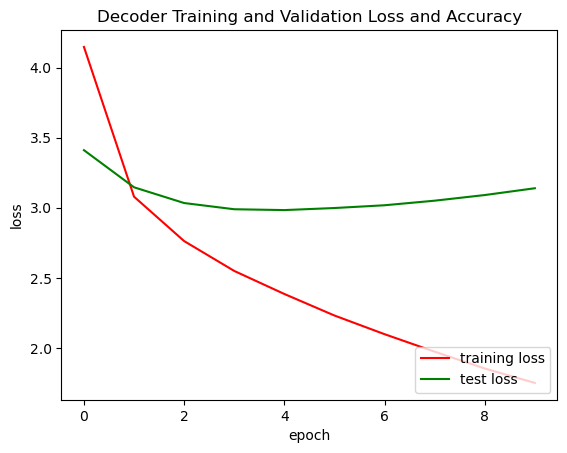

In [57]:
# Your graph
results_path = "/kaggle/working/imgae2text_10.pt"
myplot = myPlot(results_path, "Decoder Training and Validation Loss and Accuracy")
myplot.plot()

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [58]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer 
        # (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, 
        # other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize your code
        
        # batch normalisation helps to speed up training
        # your code
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01,track_running_stats=False)

        # your code for embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.resize = nn.Linear(2048, embed_size)
        # your code for RNN
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        
        # self.linear: linear layer with input: hidden layer, output: vocab size
        # --> your code
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        
        self.max_seq_length = max_seq_length
        
        self.lossfunction = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        features = features.view(features.shape[0], 2048)
        
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)
        
        # compute your feature embeddings
        # your code
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)
    
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.rnn(packed)

        outputs = self.linear(hiddens[0])
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [59]:
Decoder = DecoderRNN(vocab_size = vocab_size)
results_path = "/kaggle/working/imgae2text_10.pt"
checkpoint = torch.load(results_path)
Decoder.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [60]:
testset = test_df.drop_duplicates(subset=['file_name']).head(5)
caption_original = testset['caption']

features = []
for index, row in testset.iterrows():
    feature = features_map[row['file_name']]
    feature = torch.from_numpy(feature)
    features.append(feature)
features = torch.stack(features)
# print(features.shape)

caption_generated = Decoder.sample(features, states=None)
# vocab
caption_generated_tokens = []
for cg in caption_generated:
    tokens = [vocab.idx2word[idx.item()] for idx in cg]
    caption_generated_tokens.append(' '.join(tokens))

for index, cgt in enumerate(caption_generated_tokens):
    caption_generated_tokens[index] = caption_generated_tokens[index].split('<end>')[0]
    
caption_generated_tokens

['a tan suitcase is on a wooden bench outside ',
 'a man is standing in front of a fountain ',
 'a baby giraffe in a zoo exhibit with a large knife ',
 'a person flying a kite in the sky near a body of water ',
 'a couple of zebra standing next to each other ']

Test image: 1
Original Caption:
A motorcycle parked in a parking space next to another motorcycle.
An old motorcycle parked beside other motorcycles with a brown leather seat.
Motorcycle parked in the parking lot of asphalt.
A close up view of a motorized bicycle, sitting in a rack. 
The back tire of an old style motorcycle is resting in a metal stand. 
Generated caption: 
a tan suitcase is on a wooden bench outside 


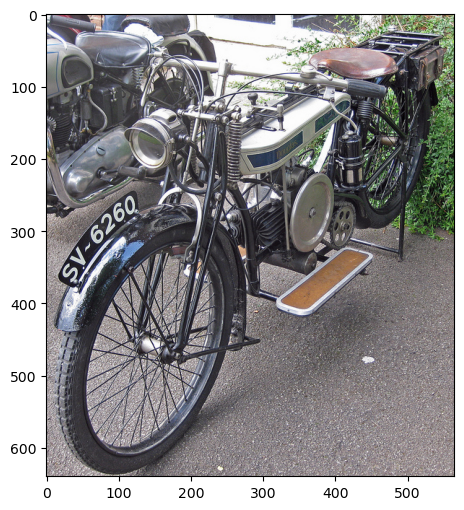

Test image: 2
Original Caption:
A young man riding a skateboard into the air.
a group of teenagers jumping a ramp on their skateboards
A time lapse image of a guy on a skate board.
Group of boys performing skateboard trick on ramp with graffiti on it
some male skateboarders are doing some tricks and grafitti
Generated caption: 
a man is standing in front of a fountain 


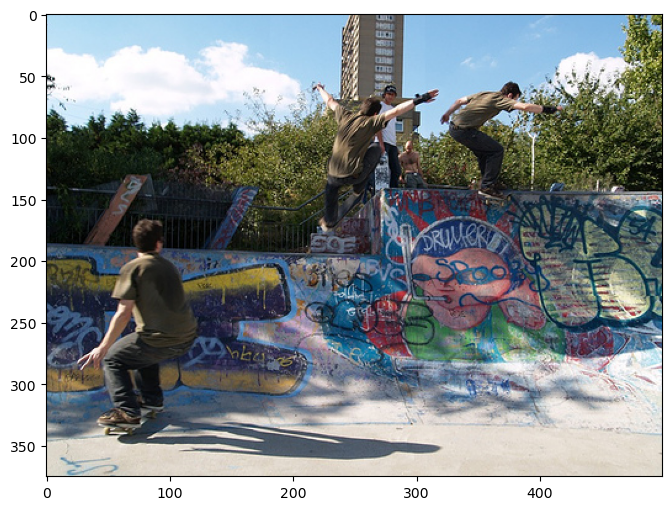

Test image: 3
Original Caption:
Three giraffes stuck behind the confines of a zoo fence. 
Three giraffes standing in the dirt in a fenced in area.
a couple of giraffes eat some food out of a trey 
Two giraffes eating together out of a trough in a fenced area.
a number of giraffes near one another 
Generated caption: 
a baby giraffe in a zoo exhibit with a large knife 


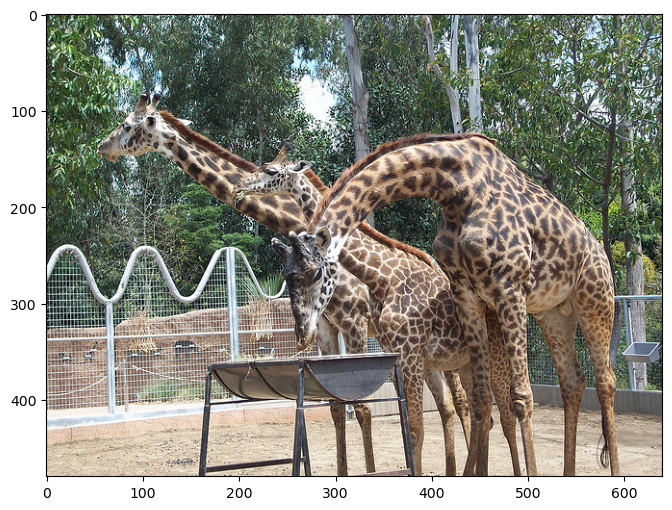

Test image: 4
Original Caption:
People gathered outside in a big field on a cloudy day
People are flying kites on a high school field.
People flying kites in a field on a cloudy day.
A host of kites being flown on a field by people.
a bunch of people are at a grass field 
Generated caption: 
a person flying a kite in the sky near a body of water 


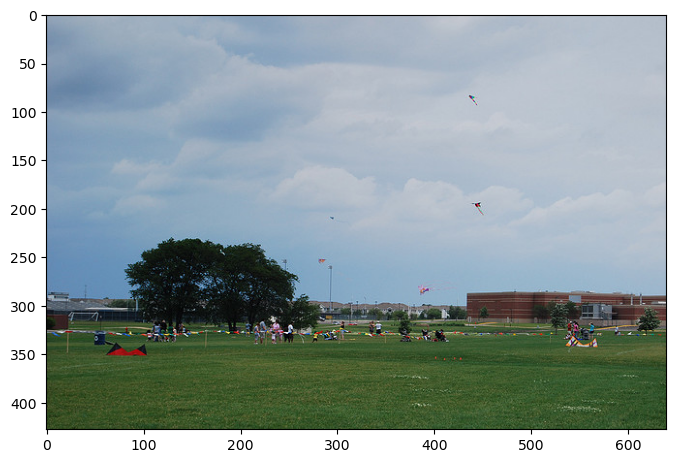

Test image: 5
Original Caption:
three zeebras standing in a grassy field walking
Three zebras are standing in an open field.
Three zebra are walking through the grass of a field.
Three zebras standing on a grassy dirt field.
Three zebras grazing in green grass field area.
Generated caption: 
a couple of zebra standing next to each other 


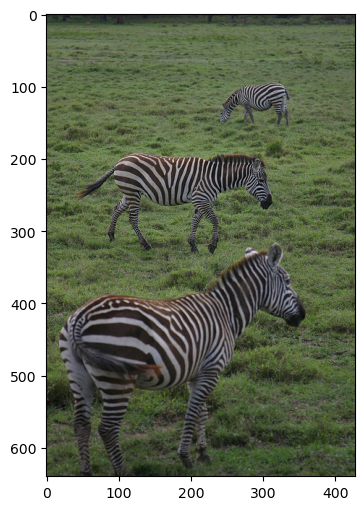

In [96]:
import matplotlib.image as mpimg
for i in range(len(testset)):
    print('Test image: ' + str(i+1))
    file_name = testset.iloc[i]['file_name']
    img = mpimg.imread("/kaggle/input/cw2-data/coco/images/" + file_name)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)
    print("Original Caption:")
    t = testset['image_id'].iloc[i]
    for x in range(5):
        print(new_file_clean[new_file_clean['image_id'] == t]['caption'].iloc[x])
    print("Generated caption: \n" + caption_generated_tokens[i])
    plt.show()
    print('='*100)

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [93]:
caption_original_all = test_df['caption']

features_all = []
for index, row in test_df.iterrows():
    feature = features_map[row['file_name']]
    feature = torch.from_numpy(feature)
    features_all.append(feature)
features_all = torch.stack(features_all)
# print(features.shape)

caption_generated = Decoder.sample(features_all, states=None)
# vocab
caption_generated_all = []
for cg in caption_generated:
    tokens = [vocab.idx2word[idx.item()] for idx in cg]
    caption_generated_all.append(' '.join(tokens))
for index, cgt in enumerate(caption_generated_all):
    caption_generated_all[index] = caption_generated_all[index].split('<end>')[0]

caption_original_all = caption_original_all.tolist()

Average BLEU score: 0.7390348523005336
The weights used for ith-gram are the default weights of (0.25, 0.25, 0.25, 0.25) because I don't think there are certain n-grams that are more important or informative than others in this case


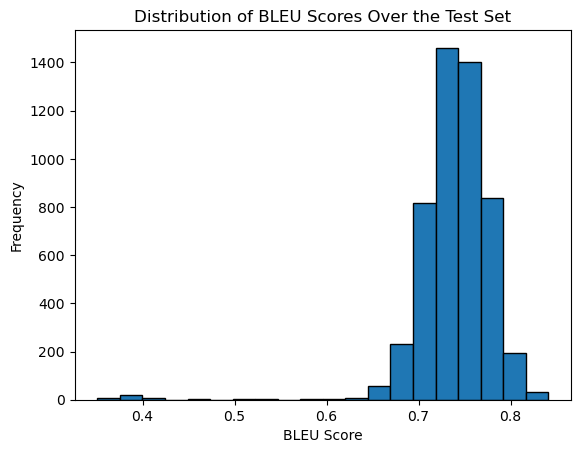

In [95]:
# TO COMPLETE
from nltk.translate.bleu_score import sentence_bleu
stats = pd.DataFrame(columns=['ref','preds','bleu','cos_sim'])

# --> Your code here!

for idx, (original_caption, generated_caption) in enumerate(zip(caption_original_all, caption_generated_all)):
    bleu_score = sentence_bleu(original_caption, generated_caption)
    stats = stats.append({
        'ref': original_caption,
        'preds': generated_caption,
        'bleu': bleu_score,
        'name': test_df.iloc[idx]['file_name'],
        'cos_sim': None  
    }, ignore_index=True)

# Calculate the average BLEU score
average_bleu = stats['bleu'].mean()
print(f"Average BLEU score: {average_bleu}")
print("The weights used for ith-gram are the default weights of (0.25, 0.25, 0.25, 0.25) because I don't think there are certain n-grams that are more important or informative than others in this case")

plt.hist(stats['bleu'], bins=20, edgecolor='black')
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.title("Distribution of BLEU Scores Over the Test Set")
plt.show()

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [98]:
# TO COMPLETE
# Sort the DataFrame by BLEU scores
sorted_stats = stats.sort_values(by='bleu', ascending=False)

# Get the highest and lowest scoring samples
highest_scoring_sample = sorted_stats.iloc[0]
lowest_scoring_sample = sorted_stats.iloc[-1]
# Display the samples
def display_sample(sample):
    print(f"Predicted Caption: {sample['preds']}")
    print(f"BLEU Score: {sample['bleu']}")
    print("Original Captions:")
    print(test_df[test_df['file_name'] == sample['name']]['caption'])

print("Highest Scoring Sample:")
display_sample(highest_scoring_sample)

print("\nLowest Scoring Sample:")
display_sample(lowest_scoring_sample)


Highest Scoring Sample:
Predicted Caption: a clock tower is in the sky 
BLEU Score: 0.8408964152537145
Original Captions:
26281    The clock tower stands tall and reads almost f...
26282     A large tower with a massive clock on it's face.
26283    A bell tower with a clock and an attractive co...
26284              A tall spiring bell tower with a clock.
26285           A clock is located on a tower with pillars
Name: caption, dtype: object

Lowest Scoring Sample:
Predicted Caption: a close up of a person holding a clock on top of a brick sidewalk 
BLEU Score: 0.3508439695638686
Original Captions:
25316    a pair of scissors with orange handles sitting...
25317      Orange handled small scissors lying on a shirt.
25318    A pair of orange scissors on a piece of clothi...
25319    A pair of orange handled scissors resting on p...
25320           A PAIR OF ORANGE SCISSORS ARE ON THE CLOTH
Name: caption, dtype: object


## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [99]:
test_valid = COCO_Features(
    df=test_df,
    vocab=vocab,
    features=features_map,
)

test_loader = DataLoader(
    test_valid,
    batch_size=64,
    shuffle=False,
    collate_fn=caption_collate_fn
)
test_loader

In [100]:
embed_layer = decoder.embed
embedding_vector = []
lengths_list = []
# Find the embedding vector
for i, (features, captions, lengths) in enumerate(test_loader):
    captions = captions.to(embed_layer.weight.device)
    emb = embed_layer(captions)
    embedding_vector.append(emb)
    lengths_list += lengths
embedding_vector = torch.cat(embedding_vector, dim=0)
# embedding_vector.shape

# Compute the average vector
average_embedding_vectors_refer = []
for i, length in enumerate(lengths_list):
    average_vector = torch.sum(embedding_vector[i, :length], dim=0) / length
    average_embedding_vectors_refer.append(average_vector.unsqueeze(0))

average_embedding_vectors_refer = torch.cat(average_embedding_vectors_refer, dim=0)
average_embedding_vectors_refer.shape

torch.Size([5077, 256])

In [101]:
# generated
caption_generated = caption_generated
lengths_generated = lengths_list

embed_layer = decoder.embed

# Find the embedding
captions = caption_generated.to(embed_layer.weight.device)
embedding_vector_generated = embed_layer(captions)

# Compute the average vector
average_embedding_vectors_generated = []
for i, length in enumerate(lengths_generated):
    average_vector = torch.sum(embedding_vector_generated[i, :length], dim=0) / length
    average_embedding_vectors_generated.append(average_vector.unsqueeze(0))

average_embedding_vectors_generated = torch.cat(average_embedding_vectors_generated, dim=0)
average_embedding_vectors_generated.shape

torch.Size([5077, 256])

Average Cosine Similarity: 0.3530926


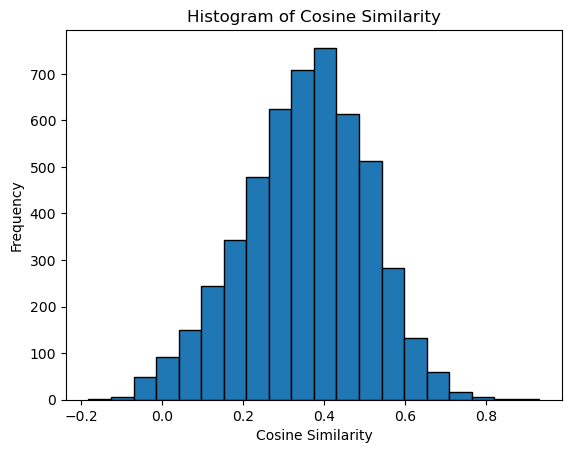

In [102]:
import torch.nn.functional as F

# Compute the cosine similarity between the average vectors
cosine_similarity_scores = F.cosine_similarity(average_embedding_vectors_generated, average_embedding_vectors_refer)
cosine_similarity_scores_np = cosine_similarity_scores.cpu().detach().numpy()

# Compute the average of cosine similarity scores
average_cosine_similarity = np.mean(cosine_similarity_scores_np)
print("Average Cosine Similarity:", average_cosine_similarity)

# Plot
plt.hist(cosine_similarity_scores_np, bins=20, edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarity')
plt.show()


#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [104]:
# Update the 'cos_sim' column in the stats DataFrame with the cosine similarity scores
for idx, cos_sim_score in enumerate(cosine_similarity_scores_np):
    stats.at[idx, 'cos_sim'] = cos_sim_score
stats.head(5)

,ref,preds,bleu,cos_sim,name
0,A motorcycle parked in a parking space next to...,a row of motorcycles parked on a sidewalk near...,0.731110,0.257062,000000000073.jpg
1,An old motorcycle parked beside other motorcyc...,a row of motorcycles parked on a sidewalk near...,0.742276,0.378551,000000000073.jpg
2,Motorcycle parked in the parking lot of asphalt.,a row of motorcycles parked on a sidewalk near...,0.731110,0.556757,000000000073.jpg
3,"A close up view of a motorized bicycle, sittin...",a row of motorcycles parked on a sidewalk near...,0.752959,0.344197,000000000073.jpg
4,The back tire of an old style motorcycle is re...,a row of motorcycles parked on a sidewalk near...,0.731110,0.527505,000000000073.jpg


In [106]:
# TO COMPLETE
# Sort the DataFrame by cosine similarity scores
sorted_stats_cos_sim = stats.sort_values(by='cos_sim', ascending=False)

# Get the highest and lowest scoring samples
highest_scoring_sample_cos_sim = sorted_stats_cos_sim.iloc[0]
lowest_scoring_sample_cos_sim = sorted_stats_cos_sim.iloc[-1]

def display_sample_cos_sim(sample):
    print(f"Predicted Caption: {sample['preds']}")
    print(f"Cosine Similarity: {sample['cos_sim']}")
    print("Original Captions:")
    print(test_df[test_df['file_name'] == sample['name']]['caption'])

print("Highest Scoring Sample by Cosine Similarity:")
display_sample_cos_sim(highest_scoring_sample_cos_sim)

print("\nLowest Scoring Sample by Cosine Similarity:")
display_sample_cos_sim(lowest_scoring_sample_cos_sim)

Highest Scoring Sample by Cosine Similarity:
Predicted Caption: a baseball player holding a bat on a field 
Cosine Similarity: 0.9311544895172119
Original Captions:
28792    A baseball player holding a bat standing on a ...
28794    Spectators closely watch a baseball game in th...
28796          a baseball player swings his bat at a pitch
28798    The batter prepares to hit the ball, while the...
28800    A man at bat holding the bat with the umpire a...
Name: caption, dtype: object

Lowest Scoring Sample by Cosine Similarity:
Predicted Caption: a stack of pairs of scissors sitting on a desk 
Cosine Similarity: -0.18218806385993958
Original Captions:
9770    Office supplies in a measuring cup sitting nex...
9771            A designers desk with scissors and pens. 
9772    A metal shelf with a cup on it full of office ...
9773    View of an area that contains several school a...
9774    A beaker full of school supplies is next to a ...
Name: caption, dtype: object


## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [107]:
# TO COMPLETE
# Rescale cosine similarity scores to match BLEU range
stats['cos_sim_rescaled'] = (stats['cos_sim'] + 1) / 2

# Calculate the mean of rescaled CS
mean_cos_sim_rescaled = stats['cos_sim_rescaled'].mean()
print(f"Mean Rescaled Cosine Similarity: {mean_cos_sim_rescaled}")

# Calculate the mean BLEU
mean_bleu = stats['bleu'].mean()
print(f"Mean BLEU Score: {mean_bleu}")


Mean Rescaled Cosine Similarity: 0.676546310532034
Mean BLEU Score: 0.7390348523005336


### BLEU:

Strengths:
- Simple to computer and easy to understand.
- Consider the difference in length between the target and generated captions

Weaknesses:
- The BLEU score is limited in its ability to capture semantic similarity between captions and is insensitive to word order.


### Cosine Similarity:
Strengths:
- More sensitive to the meaning of captions.
- Less affected by differences in caption length.

Weaknesses:
- Sensitive to the choice of word embeddings and computation of word embeddings is computationally expensive.
- Insensitive to word order.

In conclusion, BLEU emphasizes n-gram overlap, while cosine similarity captures overall semantic similarity between captions.


#### reference:
https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b#:~:text=Finally%2C%20to%20calculate%20the%20Bleu,Average%20of%20the%20Precision%20Scores.

https://www.machinelearningplus.com/nlp/cosine-similarity/#2whatiscosinesimilarityandwhyisitadvantageous

 #### 7.2 Analysis of individual examples (10 marks)
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [109]:
# TO COMPLETE
# Calculate the absolute difference between rescaled cosine similarity scores and BLEU scores
stats['score_difference'] = abs(stats['cos_sim_rescaled'] - stats['bleu'])

# Sort the DataFrame based on the score difference
sorted_stats_diff = stats.sort_values(by='score_difference')

# Get the samples with similar and dissimilar scores
similar_scores_sample = sorted_stats_diff.iloc[0]
dissimilar_scores_sample = sorted_stats_diff.iloc[-1]

# Display the samples
def display_sample_comparison(sample):
    print(f"Predicted Caption: {sample['preds']}")
    print(f"BLEU Score: {sample['bleu']}")
    print(f"Rescaled Cosine Similarity: {sample['cos_sim_rescaled']}")
    print("Original Captions:")
    print(test_df[test_df['file_name'] == sample['name']]['caption'])

print("Sample with Similar Scores:")
display_sample_comparison(similar_scores_sample)

print("\nSample with Dissimilar Scores:")
display_sample_comparison(dissimilar_scores_sample)


Sample with Similar Scores:
Predicted Caption: a cake with a knife slicing cut up a pair of scissors 
BLEU Score: 0.7259795291154771
Rescaled Cosine Similarity: 0.7259871512651443
Original Captions:
25661    A giant chocolate covered doughnut on top of a...
25662    A boy wowing at a giant iced donut cake with s...
25663           a small boy and a big chocolate donut cake
25664                A boy is amazed by a giant doughnut. 
25665    Side view of a boy with mouth open looking dow...
Name: caption, dtype: object

Sample with Dissimilar Scores:
Predicted Caption: a pizza that is sitting on a plate 
BLEU Score: 0.41113361690051975
Rescaled Cosine Similarity: 0.8295174241065979
Original Captions:
10481     A pizza with sauce, spinach and cheese on a pan.
10482          A pizza on an upside down plate on a table.
10483               A SQUARE PIZZA WITH EXTRA SAUCE ON TOP
10484    A large type pizza with cheese, spinach, and s...
10485      a pizza with some extra sauce on the top of i

For the sample with similar scores, it means the predicted caption is similar to the reference captions in terms of both n-gram overlap and overall semantic meaning.

For the sample with dissimilar scores, the low BLEU score indicates that the predicted caption has little n-gram overlap with the original captions. In this case, the predicted caption does not share any 4-grams or 3-grams with the original captions, but only shares some 2-grams and 1-grams with the original captions. This why it received a lower BLEU score.

On the other hand,the predicted caption and the original captions share some common words such as "pizza", "sauce", "cheese", "spinach", and "plate". Although the predicted caption is not an exact match for any of the original captions, it still shares some similarities with them. This is why it received higher Cosine Similarity score.